In [24]:
import os
import re
import random

import torch
from torch.utils.data import Dataset

import cv2
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt

import pydicom


In [10]:
train_df = pd.read_csv("../../datasets/Kaggle/RSNA2024/train.csv")
train_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [9]:
train_series_desc = pd.read_csv("../../datasets/Kaggle/RSNA2024/train_series_descriptions.csv")
train_series_desc

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [11]:
train_label_coor = pd.read_csv("../../datasets/Kaggle/RSNA2024/train_label_coordinates.csv")
train_label_coor

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


In [5]:
test_df = pd.read_csv("../../datasets/Kaggle/RSNA2024/test_series_descriptions.csv")
test_df.head()

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [3]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(2024)

In [21]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text) ]


class RSNA24Dataset(Dataset):
    def __init__(self, root_dir, df, series_desc_df,  image_shape, phase='train', transform=None):
        self.root_dir = root_dir
        self.df = df
        self.series_desc_df = series_desc_df
        self.image_shape = image_shape
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)
    
    def get_img_paths(self, study_id, series_desc):
        pdf = self.series_desc_df[self.series_desc_df['study_id']==study_id]
        pdf_ = pdf[pdf['series_description']==series_desc]
        allimgs = []
        for i, row in pdf_.iterrows():
            pimgs = glob(f'{self.root_dir}/train_images/{study_id}/{row["series_id"]}/*.dcm')
            pimgs = sorted(pimgs, key=natural_keys)
            allimgs.extend(pimgs)
            
        return allimgs
    
    def read_dcm_ret_arr(self, src_path):
        dicom_data = pydicom.dcmread(src_path)
        image = dicom_data.pixel_array
        image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
        img = cv2.resize(image, (self.image_shape[0], self.image_shape[1]),interpolation=cv2.INTER_CUBIC)
        assert img.shape==(self.image_shape[0], self.image_shape[1])
        return img
    
    def __getitem__(self, idx):
        x = np.zeros(self.image_shape, dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)

        # Sagittal T1
        allimgs_st1 = self.get_img_paths(st_id, 'Sagittal T1')
        if len(allimgs_st1)==0:
            print(st_id, ': Sagittal T1, has no images')
        else:
            step = len(allimgs_st1) / 10.0
            st = len(allimgs_st1)/2.0 - 4.0*step
            end = len(allimgs_st1)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    ind2 = max(0, int((i-0.5001).round()))
                    img = self.read_dcm_ret_arr(allimgs_st1[ind2])
                    x[..., j] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {st_id}, Sagittal T1')
                    pass

        # Sagittal T2/STIR
        allimgs_st2 = self.get_img_paths(st_id, 'Sagittal T2/STIR')
        if len(allimgs_st2)==0:
            print(st_id, ': Sagittal T2/STIR, has no images')
            
        else:
            step = len(allimgs_st2) / 10.0
            st = len(allimgs_st2)/2.0 - 4.0*step
            end = len(allimgs_st2)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    ind2 = max(0, int((i-0.5001).round()))
                    img = self.read_dcm_ret_arr(allimgs_st2[ind2])
                    x[..., j+10] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass

        # Axial T2
        allimgs_at2 = self.get_img_paths(st_id, 'Axial T2')
        if len(allimgs_at2)==0:
            print(st_id, ': Axial T2, has no images')
            
        else:
            step = len(allimgs_at2) / 10.0
            st = len(allimgs_at2)/2.0 - 4.0*step
            end = len(allimgs_at2)+0.0001

            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    ind2 = max(0, int((i-0.5001).round()))
                    img = self.read_dcm_ret_arr(allimgs_at2[ind2])
                    x[..., j+20] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {st_id}, Axial T2')
                    pass    
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label
    

(30, 512, 512)


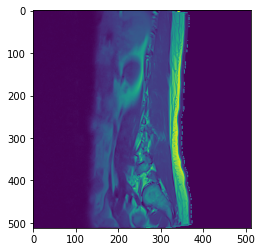

In [27]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
train_df = train_df.replace(label2id)

root_dir = "../../datasets/Kaggle/RSNA2024/"
test_ds = RSNA24Dataset(root_dir, train_df, train_series_desc, image_shape=(512, 512, 30))
print(test_ds[0][0].shape)
plt.imshow(test_ds[0][0][0])